In [11]:
%load_ext line_profiler

In [1]:
#@title: SIM Constants and setup parameters

import numpy as np

# ---------------------
# Constants
# ---------------------
r0 = 2.8179403227e-15  # Classical electron radius in meters
m_e_c2 = 0.511         # Electron rest energy in MeV

phan_size_vox: int = 128
phan_channels: int = 2 # Channel 0: Scattering Coefficient, Channel 1: Attenuation Coefficient
chan_scat: int = 0
chan_atten: int = 1

E0 = 1.0 # Effective "peak" energy of a 6MeV radiotherapy beam
scat_scale_to_m: float = 1e6 # cm^-3 to m^-3
vox_scale_to_m: float = 1e-3 # 1 metre to 1mm thereabouts
atten_scale_to_m: float = 1e2 # cm^-1 to m^-1
detec_size: int = phan_size_vox
detec_dims: int = 2
detec_bins: int = 100
detec_max_e_mev: float | None = None # Set later, based on the source spectrum and phi_min, phi_max
detec_min_e_mev: float | None = None # Set later, based on the source spectrum and phi_min, phi_max
detec_dist_isocenter_m: int = 0.5 # 0.5m from iso
detec_dist_isocenter_vox: int = int(round(detec_dist_isocenter_m / vox_scale_to_m)) # 500mm to voxels
source_dist_isocenter_m: int = 1 # 1m from iso
source_dist_isocenter_vox: int = int(round(source_dist_isocenter_m / vox_scale_to_m)) # 1000mm to voxels
alpha: float = 2 * (np.arctan((phan_size_vox*vox_scale_to_m/2) / source_dist_isocenter_m)) # Angle of the source cone beam
phi_min: float = np.pi - 0.5*np.pi - 0.5*alpha
phi_max: float = np.pi - phi_min

bin_linspace: np.ndarray | None = None # np.linspace(detec_min_e_mev, detec_max_e_mev, detec_bins) # Set after detec_min_e_mev and detec_max_e_mev are defined
theta_linspace: np.ndarray = np.linspace((0)*np.pi, (1)*np.pi, int(round(np.pi * detec_size / 2, -2)), endpoint=False) # Only image 1 pi (180 degrees)
source_spect: dict[float, float] | None = None # Defined in a little bit
source_effective_energy: float | None = None # Defined in a little bit


In [2]:
#@title SIM Grid and Detector Response (Basic)

def grid_response() -> float:
  # We compute the detector element's grid response as its area. We'll use this area later to compute the solid angle from the scatter site to the detector element.
  return (1 * vox_scale_to_m) ** 2  # Area of a single voxel in m^2


def detec_response() -> float:
  # Here, we'll treat it as a 1 second measurement time, with no degradation in signal
  return 1

In [3]:
# print the constants to verify
print(f'alpha: {alpha}')
print(f'source_dist_isocenter: {source_dist_isocenter_m} metres')

alpha: 0.12782566557746805
source_dist_isocenter: 1 metres


In [4]:
#@title SIM X-Ray Source Spectra

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_func


# --- Kramers Law Spectrum ---
def kramers_spectrum(E, E0=E0):
    """
    Kramers law: I(E) ∝ (E0 - E)/E for 0 < E < E0.
    For E=0, we define I=0 to avoid division by zero.
    """
    I = np.zeros_like(E)
    valid = (E > 0) & (E < E0)
    I[valid] = (E0 - E[valid]) / E[valid]
    return I

# --- Beta Distribution–Type Spectrum ---
def beta_spectrum(E, E0=E0, alpha=2.0, beta_param=2.0):
    """
    I(E) = I0 * (E/E0)^(alpha-1) * (1 - E/E0)^(beta_param-1)
    for 0 <= E <= E0. The function is normalized (I0 set so that
    the area under the curve equals 1) using the beta function.
    """
    x = E / E0
    I = np.zeros_like(E)
    valid = (E >= 0) & (E <= E0)
    I[valid] = x[valid]**(alpha-1) * (1 - x[valid])**(beta_param-1)
    # Normalize so that the integral over [0, E0] equals 1:
    norm = beta_func(alpha, beta_param) * E0
    return I / norm

# --- Define Energy Grid ---
# We avoid E=0 for Kramers law to prevent division by zero.
E = np.linspace(0.001, E0, 1000)

# Calculate spectra
I_kramers = kramers_spectrum(E, E0)
I_beta = beta_spectrum(E, E0, alpha=2.0, beta_param=6.0)

# Normalize for plotting (maximum value = 1)
I_kramers_norm = I_kramers / np.max(I_kramers)
I_beta_norm = I_beta / np.max(I_beta)

# --- Plotting ---
'''
plt.figure(figsize=(8,6))
plt.plot(E, I_kramers_norm, label="Kramers Spectrum (normalized)")
plt.plot(E, I_beta_norm, label="Beta Distribution Spectrum (normalized)")
plt.xlabel("Photon Energy E (MeV)")
plt.ylabel("Normalized Intensity")
plt.title(f"{E0} MeV X-ray Source Spectrum")
plt.legend()
plt.grid(True)
plt.show()
'''

# TODO Mentions of "Intensity" are a bit of a misnomer - would normalised photon counts be a better term?

def generate_source_spectrum_beta() -> dict[float, float]: # Key: E, Value: Intensity
    source_linspace: np.ndarray = np.linspace(0.0001, E0, detec_bins) # Assume source spect goes from Zero to E0
    spect = beta_spectrum(source_linspace, E0, alpha=2.0, beta_param=4.0)
    spect: dict[float, float] = dict(zip(source_linspace, spect))
    return spect

def generate_source_spectrum_monochromatic() -> dict[float, float]: # Key: E, Value: Intensity
    spect = {E0: 1.0} # Monochromatic source spectrum
    return spect

# Abstract this into one function that just serves up the spectrum that we'll use for our simulations
def generate_source_spectrum() -> dict[float, float]: # Key: E, Value: Intensity
    return generate_source_spectrum_monochromatic()

def source_spectrum_effective_energy(source_spectrum: dict[float, float]) -> float:
    # Compute a weighted average of the spectrum
    return np.average(list(source_spectrum.keys()), weights=list(source_spectrum.values()))


source_spect = generate_source_spectrum()
source_effective_energy = source_spectrum_effective_energy(source_spect)

print(f"Source spectrum: {source_spect}")
print(f"Effective energy of the source spectrum: {source_effective_energy:.2f} MeV")


Source spectrum: {1.0: 1.0}
Effective energy of the source spectrum: 1.00 MeV


Total cross section (σ_tot) = 2.561e-29 m²


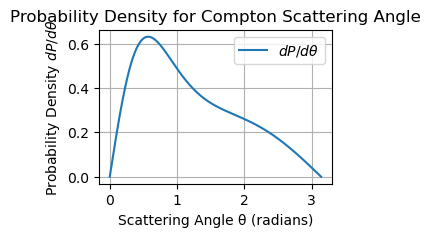

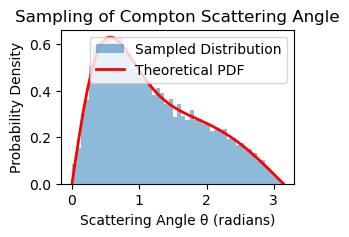

Detector energy range: 0.324 MeV to 0.353 MeV


In [5]:
#@title SIM Klein-Nishina Probability

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt


# ---------------------
# Functions
# ---------------------
def compton_energy(E, theta):
    """
    Compute the scattered photon energy E' given incident energy E (in MeV)
    and scattering angle theta (in radians) using the Compton formula.
    """
    return E / (1 + (E/m_e_c2) * (1 - np.cos(theta)))


def klein_nishina_dsigma_domega(theta, E):
    """
    Compute the Klein-Nishina differential cross section dσ/dΩ as a function of
    scattering angle theta (in radians) and incident energy E (in MeV).
    """
    E_prime = compton_energy(E, theta)
    factor = (E_prime/E)**2
    # Klein-Nishina formula
    dsigma_domega = (r0**2 / 2) * factor * ((E/E_prime) + (E_prime/E) - np.sin(theta)**2)
    return dsigma_domega, E_prime


# P.S. Scattering coefficient = Electron density * Total cross section
def total_cross_section(E):
    """
    Numerically integrate dσ/dΩ over all solid angles to obtain the total cross section σ_tot.
    Since the expression is independent of the azimuthal angle φ, the integration is:
    Than
      σ_tot = 2π ∫₀^π sinθ dθ (dσ/dΩ)(θ, E)
    """
    integral, error = integrate.quad(lambda theta: np.sin(theta) * klein_nishina_dsigma_domega(theta, E)[0], 0, np.pi)
    sigma_tot = 2 * np.pi * integral
    return sigma_tot


def probability_density(theta, E, sigma_tot):
    """
    Compute the probability density dP/dθ for scattering at angle theta.
    """
    return (2 * np.pi * np.sin(theta) * klein_nishina_dsigma_domega(theta, E)[0]) / sigma_tot

# ---------------------
# Example: Compute and Plot PDF for a Given Energy
# ---------------------
test_E = 0.662  # Incident photon energy in MeV (e.g., from Cs-137 gamma ray)
sigma_tot = total_cross_section(test_E)
print(f"Total cross section (σ_tot) = {sigma_tot:.3e} m²")

# Create an array of theta values between 0 and π
thetas = np.linspace(0, np.pi, 500)
pdf = probability_density(thetas, test_E, sigma_tot)

plt.figure(figsize=(3,2))
plt.plot(thetas, pdf, label=r'$dP/d\theta$')
plt.xlabel('Scattering Angle θ (radians)')
plt.ylabel('Probability Density $dP/d\\theta$')
plt.title('Probability Density for Compton Scattering Angle')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------
# Rejection Sampling to Generate Scattering Angles
# ---------------------
def sample_theta(E, sigma_tot, n_samples=10000):
    """
    Sample scattering angles θ from the probability density function using rejection sampling.
    """
    theta_samples = []
    # Estimate the maximum value of the PDF (used for rejection sampling)
    theta_grid = np.linspace(0, np.pi, 500)
    p_vals = probability_density(theta_grid, E, sigma_tot)
    p_max = p_vals.max()

    while len(theta_samples) < n_samples:
        # Sample a candidate uniformly from [0, π]
        theta_candidate = np.random.uniform(0, np.pi)
        # Evaluate the PDF at this candidate
        p_candidate = probability_density(theta_candidate, E, sigma_tot)
        # Sample a uniform random number between 0 and p_max
        u = np.random.uniform(0, p_max)
        if u < p_candidate:
            theta_samples.append(theta_candidate)
    return np.array(theta_samples)

# Generate samples
n_samples = 10000
theta_samples = sample_theta(test_E, sigma_tot, n_samples=n_samples)

# Plot histogram of sampled angles against the theoretical PDF
plt.figure(figsize=(3,2))
plt.hist(theta_samples, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.plot(thetas, pdf, 'r-', lw=2, label='Theoretical PDF')
plt.xlabel('Scattering Angle θ (radians)')
plt.ylabel('Probability Density')
plt.title('Sampling of Compton Scattering Angle')
plt.legend()
plt.show()

# ---------------------
# Setting our bin min, max, and linspace

# Get the min and max energy of our source spectrum
source_E_min = min(source_spect.keys())
source_E_max = max(source_spect.keys())

detec_min_e_mev = compton_energy(source_E_min, phi_max) # Minimum energy at maximum scattering angle
detec_max_e_mev = compton_energy(source_E_max, phi_min) # Maximum energy at minimum scattering angle
bin_linspace = np.linspace(detec_min_e_mev, detec_max_e_mev, detec_bins, endpoint=True)
print(f"Detector energy range: {detec_min_e_mev:.3f} MeV to {detec_max_e_mev:.3f} MeV")

In [14]:
#@title SIM 3D Phantom Definition

# Voxelised 3D medical imaging phantom (comprising of random shapes) in numpy ndarray format

import numpy as np
from material_loader import MaterialLoader



material_loader = MaterialLoader(prop_data_path="/home/samnub/dev/lircst-ana/res/nist_ele_prop.json", 
                                 atten_data_path="/home/samnub/dev/lircst-ana/res/nist_ele_atten.json",
                                 prop_comp_data_path="/home/samnub/dev/lircst-ana/res/nist_comp_prop.json",
                                 atten_comp_data_path="/home/samnub/dev/lircst-ana/res/nist_comp_atten.json",)


def create_phantom_cylinder_mask(shape=(phan_channels, phan_size_vox, phan_size_vox, phan_size_vox)) -> np.ndarray:
  # Create a cylindrical mask for the phantom
  # The cylinder is centered in the phantom and has a radius of phan_size/2
  # The cylinder is oriented along the z-axis

  # Generate voxel indices for the shape
  x_indices = np.arange(shape[-3])
  y_indices = np.arange(shape[-2])
  z_indices = np.arange(shape[-1])
  x, y, z = np.meshgrid(x_indices, y_indices, z_indices)

  mask = np.sqrt((x - phan_size_vox//2)**2 + (y - phan_size_vox//2)**2) # z is our axis of rotation, so ignore it
  return mask < phan_size_vox//2


def create_blank_voxel_phantom(background_material: str, shape=(phan_channels, phan_size_vox, phan_size_vox, phan_size_vox)) -> np.ndarray:
    phantom = np.zeros(shape, dtype=np.float32)
    # Set background material
    # Generate voxel indices for the shape
    x_indices = np.arange(shape[-3])
    y_indices = np.arange(shape[-2])
    z_indices = np.arange(shape[-1])
    x, y, z = np.meshgrid(x_indices, y_indices, z_indices)
    # Cylindrical phantom
    voxel_indices = x + y + z
    # Remove all voxels outside cylinder radius phan_size/2 from centre of phantom
    mask = create_phantom_cylinder_mask(shape)
    voxel_indices = np.logical_and(voxel_indices, mask)
    phantom[chan_scat][voxel_indices] = material_loader.calc_electron_density(background_material)
    phantom[chan_atten][voxel_indices] = material_loader.calc_atten_coeff_at_energy(background_material, source_effective_energy)

    return phantom


def create_random_voxel_phantom(shape=(phan_channels, phan_size_vox, phan_size_vox, phan_size_vox), seed: int|None=None) -> tuple[np.ndarray, dict]:
    """
    Creates a voxelized 3D medical imaging phantom with random shapes.

    Args:
      shape: The shape of the 3D array (c, x, y, z).
      num_shapes: The number of random shapes to generate.

    Returns:
      A NumPy ndarray representing the 3D phantom.
    """

    if seed is None:
      seed = np.random.randint(0, 2**31 - 1)  # Random seed if not specified

    rng = np.random.default_rng(seed)

    metadata: dict = {
        "shape": shape,
        "seed": seed,
        "inserts": [],
    }

    mu = phan_size_vox // 2
    sigma = phan_size_vox // rng.integers(4, 12) # Standard deviation for Gaussian distribution

    phantom: np.ndarray | None = None

    # We'll have three types of phantom: "Medical" and "Industrial" and "Random" - Fleshy vs. Inorganic (mostly) vs Random

    background_materials: list[str] = []
    insert_materials: list[str] = []

    phan_type = rng.choice(["medical", "industrial", "random"])

    if phan_type == "medical":
      background_materials = ["Adipose Tissue (ICRU-44)", 
                             "Muscle, Skeletal (ICRU-44)", 
                             "Lung Tissue (ICRU-44)",
                             "Tissue, Soft (ICRU-44)",
                             "Tissue, Soft (ICRU Four-Component)",
                             "Nothing", # Faster to compute than Air
                             "Water, Liquid"]
      insert_materials = [
                         "Nothing", # Cavities
                         "Bone, Cortical (ICRU-44)",
                         "Blood, Whole (ICRU-44)",
                         "Adipose Tissue (ICRU-44)",
                         "Muscle, Skeletal (ICRU-44)",
                         "Air, Dry (near sea level)",
                         "Brain, Grey/White Matter (ICRU-44)",
                         "Ovary (ICRU-44)",
                         "Testis (ICRU-44)",
                         "Eye Lens (ICRU-44)",
                         "Water, Liquid",
                         "56", # Barium
                         "53", # Iodine
                         ] # This is a horrific amalgamation of human body parts
    elif phan_type == "industrial":
      background_materials = ["Nothing", # Faster to compute than Air
                             "Water, Liquid"]
      insert_materials = [
                         "Nothing", # Subtractive geometries
                         "Glass, Lead",
                         "Lithium Fluride",
                         "Lithium Tetraborate",
                         "Bakelite",
                         "Magnesium Tetroborate",
                         "Mercuric Iodide",
                         "Photographic Emulsion (Kodak Type AA)",
                         "Photographic Emulsion  (Standard Nuclear)",
                         "C-552 Air-equivalent Plastic",
                         "Plastic Scintillator, Vinyltoluene",
                         "Cadmium Telluride",
                         "Polyethylene",
                         "Calcium Fluoride",
                         "Polyethylene Terephthalate, (Mylar)",
                         "Calcium Sulfate",
                         "Polymethyl Methacrylate",
                         "15 mmol L-1 Ceric Ammonium Sulfate Solution",
                         "Polystyrene",
                         "Cesium Iodide",
                         "Polytetrafluoroethylene, (Teflon)",
                         "Concrete, Ordinary",
                         "Polyvinyl Chloride",
                         "Concrete, Barite (TYPE BA)",
                         "Radiochromic Dye Film, Nylon Base",
                         "Ferrous Sulfate Standard Fricke",
                         "Gadolinium Oxysulfide",
                         "Gafchromic Sensor",
                         "Gallium Arsenide",
                         "Glass, Borosilicate (Pyrex)",
                         "Water, Liquid",
                         "Air, Dry (near sea level)",
                         "1", "2", "3", "6", "7", "8", "10", "11", "12", "13", "14", "17", "20", "22", "24", "26", "27", "28", "29", "30", "35", "38", "43", "47", "50", "53", "60", "74", "79", "80", "82", "92"] # Some atomic numbers for pure elements
    elif phan_type == "random":
      background_materials = ["Nothing"]
      insert_materials = material_loader.get_all_material_names()

    min_shapes: int = 1
    max_shapes: int | None = None
    if phan_type == "medical":
      max_shapes = 20
    elif phan_type == "industrial":
      max_shapes = 30
    elif phan_type == "random":
      max_shapes = 40
    num_shapes: int = rng.integers(min_shapes, max_shapes + 1)  # Random number of shapes

    anomaly_chance: float | None = None
    if phan_type == "medical":
      anomaly_chance = 0.2
    elif phan_type == "industrial":
      anomaly_chance = 0.05
    elif phan_type == "random":
      anomaly_chance = 0.1

    anomaly_min_scale: float | None = None
    anomaly_max_scale: float | None = None
    if phan_type == "medical":
      anomaly_min_scale = 0.8
      anomaly_max_scale = 4.0 # Dense tumours for example
    elif phan_type == "industrial":
      anomaly_min_scale = 0.9
      anomaly_max_scale = 1.1
    elif phan_type == "random":
      anomaly_min_scale = 0.5
      anomaly_max_scale = 2.0

    # Randomly selected background material
    background_material = rng.choice(background_materials)

    phantom = create_blank_voxel_phantom(background_material, shape)

    metadata["background_material"] = background_material
    metadata["type"] = phan_type

    for _ in range(num_shapes):
      # Randomly determine the shape of each object
      # Let's say we want more spheres and ellipsoids than cubes
      shape_type = rng.choice(["sphere", "cube", "cuboid", "ellipsoid"])

      # Random gaussian centre for the shape (centred around mid-phantom)
      center_x = int(rng.normal(mu, sigma))
      center_y = int(rng.normal(mu, sigma))
      center_z = rng.integers(0, shape[-1]) # Uniform distribution for z-axis as it's our axis of rotation

      radius = rng.integers(min(shape[-3:]) // 64, min(shape[-3:]) // 8) # Adjust radius based on phantom size

      # Generate voxel indices for the shape
      x_indices = np.arange(shape[-3])
      y_indices = np.arange(shape[-2])
      z_indices = np.arange(shape[-1])
      x, y, z = np.meshgrid(x_indices, y_indices, z_indices)

      if shape_type == "sphere":
        # Draw a sphere
        voxel_indices = (x - center_x)**2 + (y - center_y)**2 + (z - center_z)**2 <= radius**2
      elif shape_type == "cube":
        # Draw a cube
        voxel_indices = np.logical_and(np.abs(x - center_x) <= radius,
                                        np.logical_and(np.abs(y - center_y) <= radius,
                                                        np.abs(z - center_z) <= radius))
      elif shape_type == "cuboid":
        # Draw a cuboid
        # Randomly select dimensions for the cuboid
        length = radius * rng.uniform(0.5, 4)
        width = radius * rng.uniform(0.5, 4)
        height = radius * rng.uniform(0.5, 4)
        voxel_indices = np.logical_and(np.abs(x - center_x) <= length,
                                        np.logical_and(np.abs(y - center_y) <= width,
                                                        np.abs(z - center_z) <= height))
      elif shape_type == "ellipsoid":
        # Draw an ellipsoid with different radii along each axis
        a = radius * rng.uniform(0.5, 4) # x-axis radius
        b = radius * rng.uniform(0.5, 4) # y-axis radius
        c = radius * rng.uniform(0.5, 4) # z-axis radius
        voxel_indices = ((x - center_x)**2 / a**2) + ((y - center_y)**2 / b**2) + ((z - center_z)**2 / c**2) <= 1
      else:
        continue

      # Update the phantom
      # Randomly selected insert material
      insert_material = rng.choice(insert_materials)
      scat_val = material_loader.calc_electron_density(insert_material)
      atten_val = material_loader.calc_atten_coeff_at_energy(insert_material, source_effective_energy)
      # if anomoly, vary the material properties
      is_anomaly = False
      if rng.random() < anomaly_chance:
        is_anomaly = True
        anomaly_scale = rng.uniform(anomaly_min_scale, anomaly_max_scale)
        scat_val *= anomaly_scale * rng.uniform(0.95, 1.05)
        atten_val *= anomaly_scale * rng.uniform(0.95, 1.05)
      

      # Apply a 3D rotation matrix to the voxel indices
      rand_theta_x = rng.uniform(0, 2*np.pi)
      rand_theta_y = rng.uniform(0, 2*np.pi)
      rand_theta_z = rng.uniform(0, 2*np.pi)
      # Rotation matrices
      Rx = np.array([[1, 0, 0],
                     [0, np.cos(rand_theta_x), -np.sin(rand_theta_x)],
                     [0, np.sin(rand_theta_x), np.cos(rand_theta_x)]])
      Ry = np.array([[np.cos(rand_theta_y), 0, np.sin(rand_theta_y)],
                     [0, 1, 0],
                     [-np.sin(rand_theta_y), 0, np.cos(rand_theta_y)]])
      Rz = np.array([[np.cos(rand_theta_z), -np.sin(rand_theta_z), 0],
                      [np.sin(rand_theta_z), np.cos(rand_theta_z), 0],
                      [0, 0, 1]])
      
      # Let's supersample our voxel points to get a smoother rotation
      scale_factor = 2

      x_super_indices = np.arange(shape[-3] * scale_factor)
      y_super_indices = np.arange(shape[-2] * scale_factor)
      z_super_indices = np.arange(shape[-1] * scale_factor)
      x_super, y_super, z_super = np.meshgrid(x_super_indices, y_super_indices, z_super_indices)

      voxel_indices_super = np.repeat(voxel_indices, scale_factor, axis=0)
      voxel_indices_super = np.repeat(voxel_indices_super, scale_factor, axis=1)
      voxel_indices_super = np.repeat(voxel_indices_super, scale_factor, axis=2)

      coords_super = np.array([x_super[voxel_indices_super], y_super[voxel_indices_super], z_super[voxel_indices_super]])

      # Translate point of rotation to center_x, center_y, center_z
      coords_super[0] -= center_x*scale_factor
      coords_super[1] -= center_y*scale_factor
      coords_super[2] -= center_z*scale_factor

      # Apply the rotation
      coords_rotated_super = np.dot(Rz, np.dot(Ry, np.dot(Rx, coords_super)))
      x_rotated_super = coords_rotated_super[0].astype(int)
      y_rotated_super = coords_rotated_super[1].astype(int)
      z_rotated_super = coords_rotated_super[2].astype(int)

      # Translate back to original coordinates
      x_rotated_super += center_x*scale_factor
      y_rotated_super += center_y*scale_factor
      z_rotated_super += center_z*scale_factor

      # Ensure the rotated coordinates are within bounds
      x_rotated_super = np.clip(x_rotated_super, 0, (phan_size_vox-1)*scale_factor)
      y_rotated_super = np.clip(y_rotated_super, 0, (phan_size_vox-1)*scale_factor)
      z_rotated_super = np.clip(z_rotated_super, 0, (phan_size_vox-1)*scale_factor)

      # Create a new mask for the rotated coordinates
      rotated_voxel_indices_super = np.zeros_like(voxel_indices_super)
      rotated_voxel_indices_super[voxel_indices_super] = False
      rotated_voxel_indices_super[x_rotated_super, y_rotated_super, z_rotated_super] = True
      voxel_indices_super = rotated_voxel_indices_super

      # Downsample the supersampled voxel indices to the original size (ensuring True values are kept)
      voxel_indices = np.zeros_like(voxel_indices)

      # Iterate over all supersampled voxels
      for i in range(0, phan_size_vox*scale_factor, 1):
        for j in range(0, phan_size_vox*scale_factor, 1):
          for k in range(0, phan_size_vox*scale_factor, 1):
            # Check if the voxel is True in the supersampled array
            if voxel_indices_super[i, j, k]:
              # If it is, set the corresponding downsampled voxel to True
              voxel_indices[i//scale_factor, j//scale_factor, k//scale_factor] = True

      # Remove all voxels outside cylinder radius phan_size/2 from centre of phantom
      mask = create_phantom_cylinder_mask(shape)
      voxel_indices = np.logical_and(voxel_indices, mask)

      phantom[chan_scat][voxel_indices] = scat_val
      phantom[chan_atten][voxel_indices] = atten_val

      metadata["inserts"].append({
        "material": insert_material,
        "shape": shape_type,
        "center": (center_x, center_y, center_z),
        "radius": radius,
        "is_anomaly": is_anomaly,
        "scat_val": scat_val,
        "atten_val": atten_val,
      })

    return phantom, metadata

{'shape': (2, 128, 128, 128), 'seed': 602630648, 'inserts': [{'material': np.str_('13'), 'shape': np.str_('ellipsoid'), 'center': (110, 42, np.int64(32)), 'radius': np.int64(12), 'is_anomaly': False, 'scat_val': 7.831223099214544e+23, 'atten_val': np.float64(0.16588054)}, {'material': np.str_('48'), 'shape': np.str_('cuboid'), 'center': (70, 75, np.int64(44)), 'radius': np.int64(15), 'is_anomaly': False, 'scat_val': 2.2243078004098004e+24, 'atten_val': np.float64(0.503949)}, {'material': np.str_('35'), 'shape': np.str_('cube'), 'center': (72, 62, np.int64(19)), 'radius': np.int64(12), 'is_anomaly': False, 'scat_val': 1.8655075458551002e+21, 'atten_val': np.float64(0.00040508416)}, {'material': np.str_('28'), 'shape': np.str_('ellipsoid'), 'center': (62, 73, np.int64(48)), 'radius': np.int64(2), 'is_anomaly': False, 'scat_val': 2.5575828018476676e+24, 'atten_val': np.float64(0.5483631999999999)}, {'material': np.str_('40'), 'shape': np.str_('ellipsoid'), 'center': (76, 75, np.int64(55))

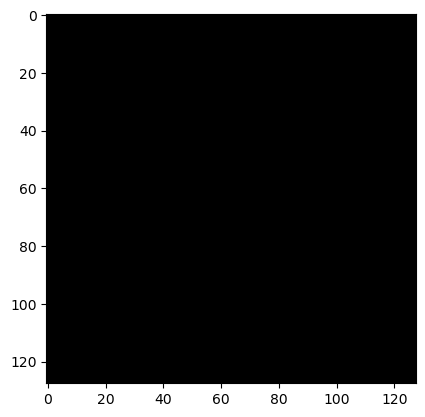

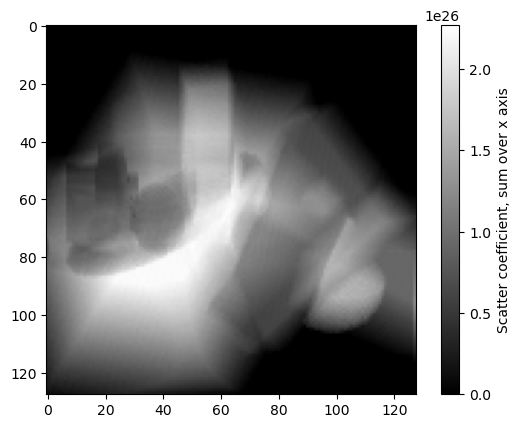

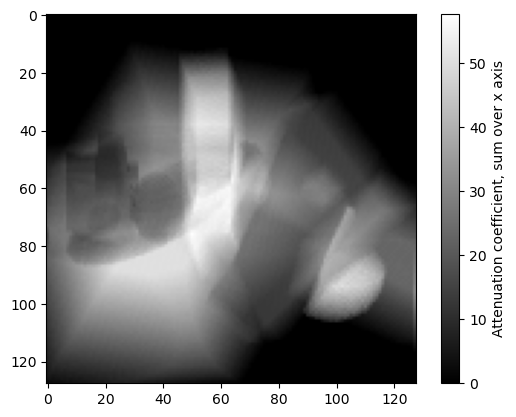

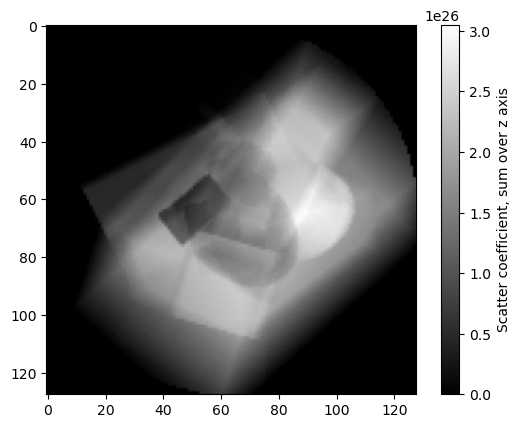

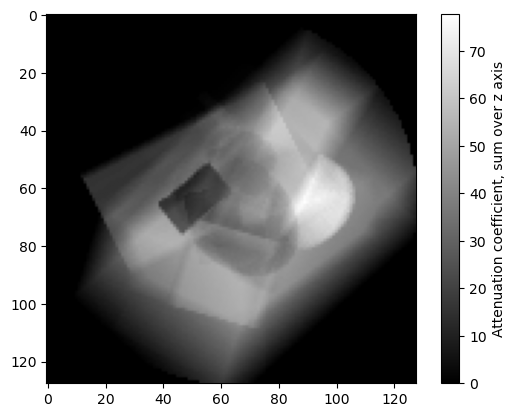

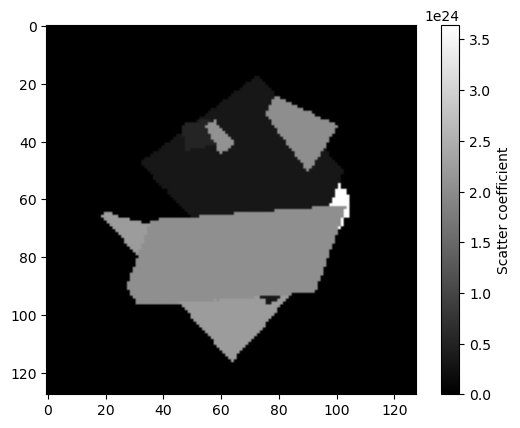

23


In [15]:
# Generate and display a phantom
phantom, phan_metadata = create_random_voxel_phantom()
print(phan_metadata)
# You can now visualize or further process phantom
# Using matplotlib for visualization
import matplotlib.pyplot as plt
plt.imshow(phantom[chan_scat,0,:,:], cmap="gray")
plt.show()


plt.imshow(np.sum(phantom, -3)[chan_scat], cmap="gray")
plt.colorbar(label="Scatter coefficient, sum over x axis")
plt.show()

plt.imshow(np.sum(phantom, -3)[chan_atten], cmap="gray")
plt.colorbar(label="Attenuation coefficient, sum over x axis")
plt.show()

plt.imshow(np.sum(phantom, -1)[chan_scat], cmap="gray")
plt.colorbar(label="Scatter coefficient, sum over z axis")
plt.show()

plt.imshow(np.sum(phantom, -1)[chan_atten], cmap="gray")
plt.colorbar(label="Attenuation coefficient, sum over z axis")
plt.show()

# Show just one slice
plt.imshow(phantom[chan_scat,:,:,90], cmap="gray")
plt.colorbar(label="Scatter coefficient")
plt.show()

print(len(phan_metadata["inserts"]))

In [16]:
#@title SIM Siddon Jacobs 3D

import math
import sys


def siddon_jacobs_3d(p1: tuple, p2: tuple, phan_size: int) -> tuple[list, list]:
  planes = phan_size + 1
  # EDGE CASE: point 1 is 1 or 2 pixels from the edge of the phantom

  d_12: float = 0 # Line integral of the attenuation coefficient
  voxels_to_traverse: list[tuple] = []
  voxels_to_traverse_path_lens: list[float] = []

  # The corner of the pixel space where the axes intersect
  b_x = 0
  b_y = 0
  b_z = 0

  # Distance between planes
  d_x = 1
  d_y = 1
  d_z = 1

  def calc_alpha_x(i: int) -> float:
    numerator = (b_x + i * d_x) - p1[0]
    denominator = p2[0] - p1[0] + sys.float_info.epsilon
    return numerator / denominator

  def calc_alpha_y(j: int) -> float:
    numerator = (b_y + j * d_y) - p1[1]
    denominator = p2[1] - p1[1] + sys.float_info.epsilon
    return numerator / denominator

  def calc_alpha_z(k: int) -> float:
    numerator = (b_z + k * d_z) - p1[2]
    denominator = p2[2] - p1[2] + sys.float_info.epsilon
    return numerator / denominator

  alpha_x_min = min(calc_alpha_x(0), calc_alpha_x(planes-1))
  alpha_x_max = max(calc_alpha_x(0), calc_alpha_x(planes-1))
  alpha_y_min = min(calc_alpha_y(0), calc_alpha_y(planes-1))
  alpha_y_max = max(calc_alpha_y(0), calc_alpha_y(planes-1))
  alpha_z_min = min(calc_alpha_z(0), calc_alpha_z(planes-1))
  alpha_z_max = max(calc_alpha_z(0), calc_alpha_z(planes-1))

  alpha_min = max(0, alpha_x_min, alpha_y_min, alpha_z_min)
  alpha_max = min(1, alpha_x_max, alpha_y_max, alpha_z_max)

  def p_x(alpha: float) -> float:
    return p1[0] + alpha * (p2[0] - p1[0])

  def p_y(alpha: float) -> float:
    return p1[1] + alpha * (p2[1] - p1[1])

  def p_z(alpha: float) -> float:
    return p1[2] + alpha * (p2[2] - p1[2])

  def phi_x(alpha: float) -> float:
    numerator = p_x(alpha) - b_x
    denominator = d_x
    return numerator / denominator

  def phi_y(alpha: float) -> float:
    numerator = p_y(alpha) - b_y
    denominator = d_y
    return numerator / denominator

  def phi_z(alpha: float) -> float:
    numerator = p_z(alpha) - b_z
    denominator = d_z
    return numerator / denominator

  # Determine i_min and i_max, j_min and j_max, k_min and k_max

  i_min: int | None = None
  i_max: int | None = None
  j_min: int | None = None
  j_max: int | None = None
  k_min: int | None = None
  k_max: int | None = None

  if p1[0] < p2[0]:
    i_min = 1 if alpha_min == alpha_x_min else math.ceil(phi_x(alpha_min))
    i_max = planes - 1 if alpha_max == alpha_x_max else math.floor(phi_x(alpha_max))
  else:
    i_max = planes - 2 if alpha_min == alpha_x_min else math.floor(phi_x(alpha_min))
    i_min = 0 if alpha_max == alpha_x_max else math.ceil(phi_x(alpha_max))

  if p1[1] < p2[1]:
    j_min = 1 if alpha_min == alpha_y_min else math.ceil(phi_y(alpha_min))
    j_max = planes - 1 if alpha_max == alpha_y_max else math.floor(phi_y(alpha_max))
  else:
    j_max = planes - 2 if alpha_min == alpha_y_min else math.floor(phi_y(alpha_min))
    j_min = 0 if alpha_max == alpha_y_max else math.ceil(phi_y(alpha_max))

  if p1[2] < p2[2]:
    k_min = 1 if alpha_min == alpha_z_min else math.ceil(phi_z(alpha_min))
    k_max = planes - 1 if alpha_max == alpha_z_max else math.floor(phi_z(alpha_max))
  else:
    k_max = planes - 2 if alpha_min == alpha_z_min else math.floor(phi_z(alpha_min))
    k_min = 0 if alpha_max == alpha_z_max else math.ceil(phi_z(alpha_max))

  # print(i_min, i_max, j_min, j_max, k_min, k_max)

  alpha_x: float | None = None
  alpha_y: float | None = None
  alpha_z: float | None = None

  if p1[0] < p2[0]:
    alpha_x = calc_alpha_x(i_min)
  elif p1[0] == p2[0]:
    alpha_x = alpha_x_max
  else:
    alpha_x = calc_alpha_x(i_max)

  if p1[1] < p2[1]:
    alpha_y = calc_alpha_y(j_min)
  elif p1[1] == p2[1]:
    alpha_y = alpha_y_max
  else:
    alpha_y = calc_alpha_y(j_max)

  if p1[2] < p2[2]:
    alpha_z = calc_alpha_z(k_min)
  elif p1[2] == p2[2]:
    alpha_z = alpha_z_max
  else:
    alpha_z = calc_alpha_z(k_max)
  
  i: int | None = None
  if True:
    numerator = min(alpha_x, alpha_y, alpha_z) + alpha_min
    denominator = 2
    i = math.floor(phi_x(numerator / denominator))
  if True:
    numerator = min(alpha_x, alpha_y, alpha_z) + alpha_min
    denominator = 2
    j = math.floor(phi_y(numerator / denominator))
  if True:
    numerator = min(alpha_x, alpha_y, alpha_z) + alpha_min
    denominator = 2
    k = math.floor(phi_z(numerator / denominator))

  # Update alpha_x, alpha_y, alpha_z and i j k
  # Accoding to whether we cross an x, y or z plane

  a_xu = d_x / (abs(p2[0] - p1[0]) + sys.float_info.epsilon)
  a_yu = d_y / (abs(p2[1] - p1[1]) + sys.float_info.epsilon)
  a_zu = d_z / (abs(p2[2] - p1[2]) + sys.float_info.epsilon)

  i_u: int = 1 if p1[0] < p2[0] else -1
  j_u: int = 1 if p1[1] < p2[1] else -1
  k_u: int = 1 if p1[2] < p2[2] else -1

  alpha_c = alpha_min
  d_conv = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

  while alpha_c < alpha_max:

    i_to_add: int = i
    j_to_add: int = j
    k_to_add: int = k

    length: float = 0

    if (alpha_x <= alpha_y) and (alpha_x <= alpha_z):
      length = (alpha_x - alpha_c) * d_conv

      alpha_c = alpha_x
      alpha_x = alpha_x + a_xu
      
      i = i + i_u

    elif (alpha_y <= alpha_x) and (alpha_y <= alpha_z):
      length = (alpha_y - alpha_c) * d_conv

      alpha_c = alpha_y
      alpha_y = alpha_y + a_yu

      j = j + j_u
      
    else: # alpha_z is smallest
      length = (alpha_z - alpha_c) * d_conv

      alpha_c = alpha_z
      alpha_z = alpha_z + a_zu
      k = k + k_u

    if alpha_c > alpha_max:
      break
    
    if length > 0:
      voxels_to_traverse.append((i_to_add, j_to_add, k_to_add))
      voxels_to_traverse_path_lens.append(length)

  return voxels_to_traverse, voxels_to_traverse_path_lens



Traversed voxels: [(1, 2, 0), (1, 3, 0), (1, 4, 0), (1, 5, 0), (1, 6, 0), (1, 7, 0), (1, 8, 0), (1, 9, 0), (1, 10, 0), (1, 11, 0), (1, 12, 0), (1, 13, 0), (1, 14, 0), (1, 15, 0), (1, 16, 0), (1, 17, 0), (1, 18, 0), (1, 19, 0), (1, 20, 0), (1, 21, 0), (1, 22, 0), (1, 23, 0), (1, 24, 0), (1, 25, 0), (1, 26, 0), (1, 27, 0), (1, 28, 0), (1, 29, 0), (1, 30, 0), (1, 31, 0), (1, 32, 0), (1, 33, 0), (1, 34, 0), (1, 35, 0), (1, 36, 0), (1, 37, 0), (1, 38, 0), (1, 39, 0), (1, 40, 0), (1, 41, 0), (1, 42, 0), (1, 43, 0), (1, 44, 0), (1, 45, 0), (1, 46, 0), (1, 47, 0), (1, 48, 0), (1, 49, 0), (1, 50, 0), (1, 51, 0), (1, 52, 0), (1, 53, 0), (1, 54, 0), (1, 55, 0), (1, 56, 0), (1, 57, 0), (1, 58, 0), (1, 59, 0), (1, 60, 0), (1, 61, 0), (1, 62, 0), (1, 63, 0), (1, 64, 0), (1, 65, 0), (1, 66, 0), (1, 67, 0), (1, 68, 0), (1, 69, 0), (1, 70, 0), (1, 71, 0), (1, 72, 0), (1, 73, 0), (1, 74, 0), (1, 75, 0), (1, 76, 0), (1, 77, 0), (1, 78, 0), (1, 79, 0), (1, 80, 0), (1, 81, 0), (1, 82, 0), (1, 83, 0), (1, 8

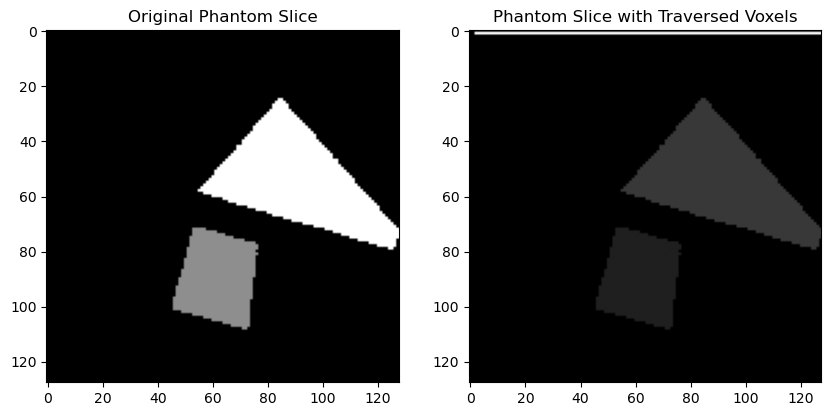

In [17]:
#@title Testing Siddon Jacobs 3D

# Use the siddon_jacobs_3d function defined above, with 2 random points, and visualise the traversed pixels in an ndarray plot

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'phantom' and 'siddon_3d' are defined as in the provided code.

# Generate two random 3D points within the phantom's boundaries.
phantom_shape = phantom.shape
p1 = (1.5, 1, 0)
p2 = (1.5, 128, 0)

# Call the siddon_3d function.
voxels_traversed, path_lengths = siddon_jacobs_3d(p1, p2, phan_size_vox)

print(f"Traversed voxels: {voxels_traversed}")
print(f"Path lengths: {path_lengths}")

# Create a copy of the phantom to visualize traversed voxels.
phantom_visualization = np.copy(phantom)

# Mark the traversed voxels.
for voxel in voxels_traversed:
  if 0 <= voxel[0] < phantom_shape[-3] and 0 <= voxel[1] < phantom_shape[-2] and 0 <= voxel[2] < phantom_shape[-1]:
    phantom_visualization[chan_scat][voxel] = 1e25  # Or any other distinct value.
    phantom_visualization[chan_atten][voxel] = 1.0  # Or any other distinct value.

# Display a slice of the phantom with the traversed voxels highlighted.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(phantom[chan_scat, :, :, 0], cmap="gray")
plt.title("Original Phantom Slice")
plt.subplot(1, 2, 2)
plt.imshow(phantom_visualization[chan_scat, :, :, 0], cmap="gray")
plt.title("Phantom Slice with Traversed Voxels")
plt.show()


In [18]:
#@title SIM Full Generalised Radon Transform for One detector point

import numpy as np

debug_list_energies: dict[float, float] = {} # Key: Energy, Value: Intensity


def generalised_radon_transform(phantom: np.ndarray,
                                theta: float,
                                detec_point: tuple,
                                source_spect: dict[float, float], # Key: Energy, Value: Intensity
                                bin_linspace: np.ndarray) -> list[float]: # Energy bins for this pixel
  # Take line integral for our given theta and detec_point (coordinates on the detector grid, final axis is energy bin)

  # P.S. Mentions of "Intensity" are a bit of a misnomer, as the defininition changes depending on where we are at in the simulation.
  e_intensities: dict[float, float] = {} # Key: Energy, Value: Accumulated intensity

  # Small nested function to check if a given coord is within the phantom bounds
  def is_within_bounds(coord: tuple) -> bool:
    return 0 <= coord[0] < phantom.shape[-3] and 0 <= coord[1] < phantom.shape[-2] and 0 <= coord[2] < phantom.shape[-1]

  def angle_between_points(a: tuple, b: tuple, c: tuple) -> float:
    # Calculate angle between a, b, c, in radians (b being the vertex), using dot product between vectors ba and bc
    ba = (a[0] - b[0], a[1] - b[1], a[2] - b[2])
    bc = (c[0] - b[0], c[1] - b[1], c[2] - b[2])
    dot_product = np.dot(ba, bc)
    norm_ba = np.linalg.norm(ba)
    norm_bc = np.linalg.norm(bc)
    if norm_ba == 0 or norm_bc == 0:
      return 0.0
    cos_angle = dot_product / (norm_ba * norm_bc)
    # Clamp the value to avoid numerical issues with acos
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.arccos(cos_angle)

  def dist_between_points_vox(a: tuple, b: tuple) -> float:
    # Calculate the Euclidean distance between two points in voxel space
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)

  # We'll rotate around the z axis
  detec_point_physical: np.ndarray = np.array([-detec_dist_isocenter_vox + phan_size_vox*0.5, detec_point[0], detec_point[1]]) # left side
  detec_point_physical_opposite: np.ndarray = np.array([detec_dist_isocenter_vox - phan_size_vox*0.5, detec_point[0], detec_point[1]]) # left side
  source_point_physical: np.ndarray = np.array([phan_size_vox * 0.5, -source_dist_isocenter_vox + phan_size_vox*0.5, phan_size_vox * 0.5]) # above

  # Move all points so that our phantom centre is the new origin, before we rotate
  detec_point_physical = detec_point_physical - phan_size_vox * 0.5
  detec_point_physical_opposite = detec_point_physical_opposite - phan_size_vox * 0.5
  source_point_physical = source_point_physical - phan_size_vox * 0.5

  # Translate all points around the z axis by theta
  rot_mat: np.ndarray = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
  detec_point_physical = rot_mat @ detec_point_physical.T
  detec_point_physical_opposite = rot_mat @ detec_point_physical_opposite.T
  source_point_physical = rot_mat @ source_point_physical.T

  # Move all points back to their original positions
  detec_point_physical = detec_point_physical + phan_size_vox * 0.5
  detec_point_physical_opposite = detec_point_physical_opposite + phan_size_vox * 0.5
  source_point_physical = source_point_physical + phan_size_vox * 0.5

  # Let's just turn our points into tuples for ease
  detec_point_physical = (detec_point_physical[0], detec_point_physical[1], detec_point_physical[2])
  detec_point_physical_opposite = (detec_point_physical_opposite[0], detec_point_physical_opposite[1], detec_point_physical_opposite[2])
  source_point_physical = (source_point_physical[0], source_point_physical[1], source_point_physical[2])

  # Get traversed pixels from detec_point_physical to detec_point_physical_opposite
  rd_r_voxels_all, rd_r_voxels_all_lens = siddon_jacobs_3d(detec_point_physical, detec_point_physical_opposite, phan_size_vox)

  # Every voxel in this line is the result of a scatter incident, tracing back to the source.
  # So for each of these voxels (r's), also get the siddon result for r back to our source

  # We can save (very little) computation time by having a running tally of our rd_r attenuation integral
  # This is under the assumption that our iterations go from detector -> point r
  atten_rd_r_exp_running_integral: float = 0

  for _, (rd_r_voxel, rd_r_voxel_len) in enumerate(dict(zip(rd_r_voxels_all, rd_r_voxels_all_lens)).items()):
    if not is_within_bounds(rd_r_voxel):
      continue

    # Add to the rd_r attenuation tally before we keep looping over E's
    atten_rd_r_exp_running_integral = atten_rd_r_exp_running_integral + (phantom[chan_atten][rd_r_voxel]*atten_scale_to_m) * (rd_r_voxel_len*vox_scale_to_m)

    # Grab our scattering coefficient now, and if no scattering can occur here,
    # we do not even need to consider propagating back up to r_rs
    r_scat_coef: float = phantom[chan_scat][rd_r_voxel]
    if r_scat_coef == 0:
      continue

    # Get phi between this voxel and source
    phi: float = np.pi - angle_between_points(source_point_physical, rd_r_voxel, detec_point_physical)

    # Calculate angle of source, subtended by isocenter and point r
    r_s_i_angle: float = angle_between_points(
      (phan_size_vox * 0.5, phan_size_vox * 0.5, phan_size_vox * 0.5), # isocenter
      source_point_physical,
      rd_r_voxel
    )

    # Get all the voxels between this voxel and the source
    r_rs_voxels, r_rs_voxels_lens = siddon_jacobs_3d(rd_r_voxel, source_point_physical, phan_size_vox)

    atten_r_rs_exp_integral: float = 0
    for r_rs_voxel, r_rs_voxel_len in zip(r_rs_voxels, r_rs_voxels_lens):
      if not is_within_bounds(r_rs_voxel):
        continue
      atten_r_rs_exp_integral = atten_r_rs_exp_integral + (phantom[chan_atten][r_rs_voxel]*atten_scale_to_m) * (r_rs_voxel_len*vox_scale_to_m)

    # We can now compute the inverse square laws for this voxel from source and detector
    # This is under the assumption that we have a cone-beam source - a hypothetical perfect parallel beam would not need this
    inv_sq_rd_r: float = 1 / ((dist_between_points_vox(detec_point_physical, rd_r_voxel) * vox_scale_to_m) ** 2)
    inv_sq_r_rs: float = 1 / ((dist_between_points_vox(rd_r_voxel, source_point_physical) * vox_scale_to_m) ** 2)

    # Let's cache computed Klein-Nishina values for each E', as many will be reused (when phi is fixed)
    klein_nishina_cache_Eprime_fixed_phi: dict[float, tuple[float, float]] = {} # Key: Eprime, Value (Klein-Nishina prob, scattered energy)

    # Let's integrate over all our desired energy bins
    for E_idx, E in np.ndenumerate(bin_linspace):
      e_intensity: float | None = None
      
      grid_detec_response: float = grid_response() * detec_response()
      # Multiply the grid response by the solid angle from the scatter point to the detector
      # This steradian unit will cancel out the Klein-Nishina dsigma/domega omega term later
      # P.S. the solid angle does not need to be circular, in our case, our detector area is a square
      # rd_area: float = vox_scale_to_m * vox_scale_to_m # Area of a single detector element
      # r_rd_solid_angle: float = rd_area / ((dist_between_points_vox(detec_point_physical, rd_r_voxel) * vox_scale_to_m) ** 2) # steradians
      # grid_detec_response = grid_detec_response * r_rd_solid_angle

      # Let's integrate over E' which will be from E up to E0, discretised
      # Nested loop: For each voxel from r to rs, see how the intensity lowers due to atten. + inverse sq. law.
      # These are all the energies that RESULT in our E, so sum up these intensities as they come
      eprimes_intensity_integral: float = 0
      for _, Eprime in enumerate(source_spect): # Keys are Eprimes
        # A quick check here to see if our E' is greater than E
        if Eprime < E:
          continue

        eprime_intensity: float | None = None

        # At the end of that voxel loop, we can then compute the Klein-Nishina prob that our scat originating from E' happens
        # and scale our tally accordingly
        klein_nishina_prob: float | None = None
        Escat: float | None = None
        if Eprime in klein_nishina_cache_Eprime_fixed_phi:
          klein_nishina_prob, Escat = klein_nishina_cache_Eprime_fixed_phi[Eprime]
        else:
          klein_nishina_prob, Escat = klein_nishina_dsigma_domega(phi, Eprime)
          klein_nishina_cache_Eprime_fixed_phi[Eprime] = (klein_nishina_prob, Escat)

        # If scattered energy does not fall within our energy bin, skip this Eprime
        if Escat < E or Escat > (bin_linspace[E_idx[0]+1] if E_idx[0] + 1 < len(bin_linspace) else np.inf):
          continue

        source_I_at_Eprime: float = source_spect[Eprime] * np.cos(r_s_i_angle) # Proportional to cosine rule
        scaled_I_r_rs: float = source_I_at_Eprime * inv_sq_r_rs

        eprime_intensity = scaled_I_r_rs * (np.e**(-atten_r_rs_exp_integral)) * klein_nishina_prob
        eprimes_intensity_integral = eprimes_intensity_integral + eprime_intensity

      # If we have no Eprime intensities, skip this E
      if eprimes_intensity_integral == 0:
        continue

      # Now we can compute the final intensity from scatter point r from source all the way to detector, for this energy bin
      e_intensity = grid_detec_response * (np.e**(-atten_rd_r_exp_running_integral)) * inv_sq_rd_r * eprimes_intensity_integral
      # Don't forget to tag on our scattering coefficient!
      # Teeechnically this should be applied to the whole integral if our logic is for total energy integration
      # But for us, we are discretising bins
      e_intensity = e_intensity * (r_scat_coef*scat_scale_to_m * rd_r_voxel_len*vox_scale_to_m) # Convert electrons*cm^-3 to electrons*m^-3
      if E in e_intensities:
        e_intensities[E] = e_intensities[E] + e_intensity
      else:
        e_intensities[E] = e_intensity

  detec_point_output: list[float] = []
  for _, bin_E in np.ndenumerate(bin_linspace):
    detec_point_output.append(e_intensities[bin_E] if bin_E in e_intensities else 0)
  return detec_point_output

In [24]:
#@title SIM Iterating Radon transform over detector point grid

from multiprocessing import Pool, cpu_count

debug: bool = False
debug_col_pixel: int = 79 # aka row

# TODO: debug:
theta = np.pi/2 # 0.5*np.pi*(4/5)

# For sinogram generation, we'd like to go column by column (slice by slice)
def generalised_radon_transform_col(phantom: np.ndarray,
                                    theta: float,
                                    detec_col: int,
                                    source_spect: dict[float, float],
                                    bin_linspace: np.ndarray) -> list[list[float]]:
  detec_col_output: list[list[float]] = []
  
  if debug:
    # Just do one pixel
    for detec_row in range(0, detec_size):
      if detec_row == debug_col_pixel:
        detec_col_output.append(generalised_radon_transform(phantom, theta, (detec_row, detec_col), source_spect, bin_linspace))
      
        plt.plot(bin_linspace, detec_col_output[debug_col_pixel])
        plt.show()
      
      else:
        detec_col_output.append([0] * len(bin_linspace))
    return detec_col_output

  for detec_row in range(0, detec_size):
    detec_col_output.append(generalised_radon_transform(phantom, theta, (detec_row, detec_col), source_spect, bin_linspace))
  return detec_col_output


def radon_over_detector_pixels(phantom: np.ndarray, detec_size: int, detec_dims: int, detec_bins: int, sinogram_slice: int | None) -> np.ndarray:
  sinogram_mode: bool = True if sinogram_slice is not None else False
  
  detec_shape: list | tuple = []

  if (not sinogram_mode) or debug:
    for i in range(0, detec_dims):
      detec_shape.append(detec_size)
  else:
    detec_shape.append(detec_size)
    detec_shape.append(len(theta_linspace)) # Round to nearest 100

  detec_shape.append(detec_bins) # Our bins are not included in the dims size, but we tag it on!
  detec_shape = tuple(detec_shape)
  detec_output: np.ndarray = np.zeros(detec_shape)

  if debug:
    print("DEBUG MODE: Running in serial mode")
    max_rows: int = 1
    for detec_row in range(0, max_rows):
      print(f"Processing row {detec_row}")
      detec_output[detec_row,:] = generalised_radon_transform_col(phantom, theta, detec_row, source_spect, bin_linspace)
    return detec_output

  # Trying out multiprocessing
  cpus: int = cpu_count()
  with Pool(processes=cpus) as pool:

    reses: dict[tuple, np.ndarray] = {}
    
    if not sinogram_mode:
      for y in range(0, detec_size):
        res = pool.apply_async(generalised_radon_transform_col, args=(phantom,
                                                                      theta,
                                                                      y,
                                                                      source_spect,
                                                                      bin_linspace
                                                                      ))
        reses[(y)] = res
      for y in range(0, detec_size):
        detec_output[:,y] = reses[(y)].get()
    else:
      for sinogram_theta in theta_linspace.tolist():
        res = pool.apply_async(generalised_radon_transform_col, args=(phantom,
                                                                      sinogram_theta,
                                                                      sinogram_slice,
                                                                      source_spect,
                                                                      bin_linspace
                                                                      ))
        reses[(sinogram_theta)] = res
      for sinogram_index, sinogram_theta in enumerate(theta_linspace):
        detec_output[:,sinogram_index] = reses[(sinogram_theta)].get()

  return detec_output


In [25]:
#@title Execution of Analytical model

# Use the radon_over_detector_pixels function over our phantom defined above

import matplotlib.pyplot as plt
# Assuming 'phantom', 'phan_size', 'chan_scat_coef', and 'chan_atten_coef' are defined from previous code

print("Beginning the radon transform...")

# blank_phantom = create_blank_voxel_phantom("Water, Liquid")

# Example usage:
radon_output = radon_over_detector_pixels(phantom, detec_size, detec_dims, detec_bins, sinogram_slice=None)

Beginning the radon transform...


Radon output shape: (128, 128, 100)


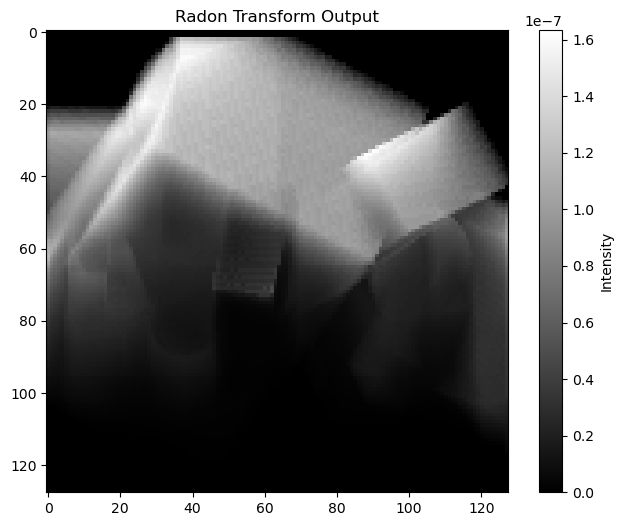

Min and max values in radon output: 0.0, 2.3127660599010025e-08


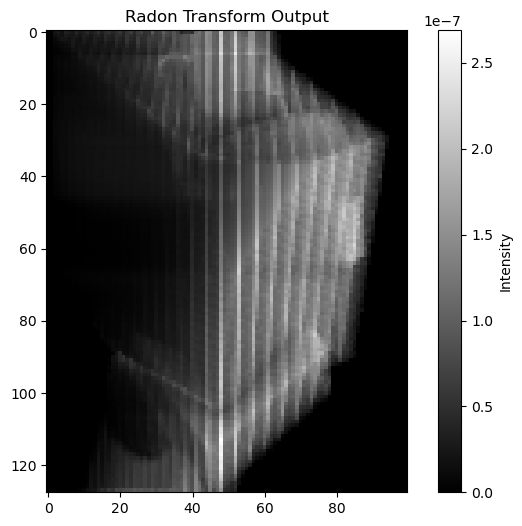

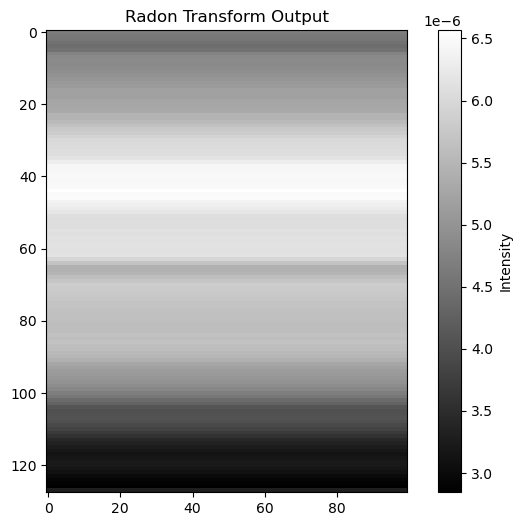

In [26]:
from IPython.display import display, clear_output


def display_radon_output(radon_output: np.ndarray):
    # Print shape of the output
    print(f"Radon output shape: {radon_output.shape}")

    if False:
        for i in range(0, detec_size):
            fig = plt.figure(figsize=(8, 6))
            plt.imshow(radon_output[i, :, :], cmap="gray") 
            plt.title(f"Energy bins for var {i}")
            plt.colorbar(label="Intensity")
            display(fig)
            clear_output(wait=True)
            plt.pause(0.001)

    if False:
        for i in range(0, len(theta_linspace)):
            for j in range(detec_size):
                bins_at_pixel = radon_output[i, j, :]
                max_bin_value = np.max(bins_at_pixel)
                if max_bin_value == 0:
                    continue
                fig = plt.figure(figsize=(8, 6))
                plt.plot(bin_linspace, bins_at_pixel, label=f"Theta {i}, Detec Pixel {j}")
                plt.title(f"Energy bins for theta {i}, detec pixel {j}, max value {max_bin_value:.2f}")
                display(fig)
                clear_output(wait=True)
                plt.pause(0.001)

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(np.sum(radon_output, axis=2), cmap="gray") # Visualising the sum over our energy bins (integrate energy)
    plt.title("Radon Transform Output")
    plt.colorbar(label="Intensity")
    plt.show()

    print(f"Min and max values in radon output: {np.min(radon_output)}, {np.max(radon_output)}")

    plt.figure(figsize=(8, 6))
    plt.imshow(np.sum(radon_output, axis=0), cmap="gray") # Visualising the energy bins
    plt.title("Radon Transform Output")
    plt.colorbar(label="Intensity")
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.imshow(np.repeat(np.sum(np.sum(radon_output, axis=0), axis=-1, keepdims=True), 100, axis=-1), cmap="gray") # Visualising the energy bins
    plt.title("Radon Transform Output")
    plt.colorbar(label="Intensity")
    plt.show()


display_radon_output(radon_output)

In [ ]:
%lprun -f generalised_radon_transform radon_over_detector_pixels(phantom, detec_size, detec_dims, detec_bins, sinogram_slice=62)

In [24]:
#@title Full data generation pipeline

import random
import os
import time

def generate_data_pipeline():
    # Generate N amount of phantoms
    # For each one, we take sinogram slices as individual samples
    # We will rely on the default configuration for our parameters

    N: int = 125
    for i in range(0, N):
        phantom, phan_metadata = create_random_voxel_phantom()

        print(f"Generated phantom {i+1}/{N} with metadata: {phan_metadata}")

        # Create timestamp-based file directory for this phantom
        timestamp: float = time.time()
        file_dir: str = f"../data/{int(timestamp)}"
        os.makedirs(file_dir)

        metadata: dict = {
            "vox_scale_to_m": vox_scale_to_m,
            "scat_scale_to_m": scat_scale_to_m,            
            "atten_scale_to_m": atten_scale_to_m,
            "source_dist_isocenter_m": source_dist_isocenter_m,
            "source_spect": source_spect,
            "bin_linspace": bin_linspace,
            "theta_linspace": theta_linspace,
            "phan_metadata": phan_metadata,
        }

        # Save the metadata
        np.save(f"{file_dir}/meta.npy", metadata)

        # To check whether our slices are "empty", let's first get the scat and atten coef of our background material
        phan_background_name: str = phan_metadata["background_material"]
        blank_phantom = create_blank_voxel_phantom(phan_background_name, phantom.shape)

        slice_indices: list[int] = list(range(0, detec_size))
        random.shuffle(slice_indices) # Reduce bias in our data
        for j, slice_index in enumerate(slice_indices):
            # Generate ground-truth phantom slice first
            phan: np.ndarray = phantom[:, :, :, slice_index]
            blank_phan: np.ndarray = blank_phantom[:, :, :, slice_index]
            # Check if the slice is empty
            if not np.subtract(phan, blank_phan).any():
                # Empty slice, so we skip it
                continue
            np.save(f"{file_dir}/phan-{slice_index}.npy", phan)

            timestamp_delta_a: float = time.time()

            sinogram_output: np.ndarray = radon_over_detector_pixels(phantom, 
                                                                     detec_size, 
                                                                     detec_dims, 
                                                                     detec_bins, 
                                                                     sinogram_slice=slice_index)
            # Save the sinogram output
            np.save(f"{file_dir}/sino-{slice_index}.npy", sinogram_output)

            timestamp_delta_b: float = time.time()
            print(f"Generated sinogram slice {slice_index} ({j+1}/{len(slice_indices)}) for phantom {int(timestamp)} ({i}) in {round(timestamp_delta_b - timestamp_delta_a)} seconds")


generate_data_pipeline()


Generated phantom 1/125 with metadata: {'shape': (2, 128, 128, 128), 'inserts': [{'material': np.str_('Concrete, Ordinary'), 'shape': np.str_('ellipsoid'), 'center': (65, 75, 63), 'radius': 15, 'is_anomaly': False, 'scat_val': 7.054551758512521e+23, 'atten_val': np.float64(0.14938499999999996)}, {'material': np.str_('47'), 'shape': np.str_('cube'), 'center': (61, 77, 87), 'radius': 10, 'is_anomaly': False, 'scat_val': 2.7551655305445595e+24, 'atten_val': np.float64(0.621705)}, {'material': np.str_('38'), 'shape': np.str_('cube'), 'center': (73, 43, 42), 'radius': 4, 'is_anomaly': False, 'scat_val': 6.633825254559176e+23, 'atten_val': np.float64(0.1451356)}, {'material': np.str_('Polytetrafluoroethylene, (Teflon)'), 'shape': np.str_('cuboid'), 'center': (73, 105, 34), 'radius': 2, 'is_anomaly': False, 'scat_val': 6.502855118565844e+23, 'atten_val': np.float64(0.1375875)}, {'material': np.str_('Cesium Iodide'), 'shape': np.str_('sphere'), 'center': (67, 76, 76), 'radius': 14, 'is_anomaly

Process ForkPoolWorker-37445:
Process ForkPoolWorker-37460:
Process ForkPoolWorker-37446:
Process ForkPoolWorker-37456:
Process ForkPoolWorker-37442:
Process ForkPoolWorker-37455:
Process ForkPoolWorker-37443:
Process ForkPoolWorker-37447:
Process ForkPoolWorker-37457:
Process ForkPoolWorker-37459:
Process ForkPoolWorker-37452:
Process ForkPoolWorker-37441:
Process ForkPoolWorker-37451:
Process ForkPoolWorker-37453:
Process ForkPoolWorker-37444:
Process ForkPoolWorker-37449:
Process ForkPoolWorker-37450:
Process ForkPoolWorker-37458:
Process ForkPoolWorker-37448:
Process ForkPoolWorker-37454:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

KeyboardInterrupt: 